<table>
<tr>
<td width=15%><img src="./img/UGA.png"></img></td>
<td><center><h1>Introduction à la Recherche Opérationelle</h1><br/>M2 Statistique Science des Données (SSD)</center></td>
<td width=15%>
<a href="https://www-ljk.imag.fr/membres/Anatoli.Iouditski/" style="font-size: 16px; font-weight: bold">Anatoli Juditsky</a><br/>
<a href="http://www.iutzeler.org" style="font-size: 16px; font-weight: bold">Franck Iutzeler</a> </td>
</tr>
</table>

<br/><br/>
<center><a style="font-size: 30pt; font-weight: bold">TP 2 - Dantzig Selector </a></center>
<br/><br/>

# 1- Problème de régression parcimonieuse et Dantzig Selector

On considère le modèle de régression normale
$$ y=X\theta+\sigma\xi,\;\;\xi\sim \mathcal{N}(0, I_m),$$
où  $X\in \mathbb{R}^{m\times n}$ et $y\in \mathbb{R}^m$ sont les observables, et $\theta\in \mathbb{R}^n$ est le paramètre inconnu. 


L'estimateur de $\theta$ de *``Dantzig Selector''* (cf. Candes, E., Tao, T. (2007). *The Dantzig selector: Statistical estimation when $p$ is much larger than $n$*. The Annals of Statistics, 2313-2351) peut être utilisé pour estimer $\theta$ dans le cas d'un modèle surparamétré, quand la dimension $n$ de $\theta$ est supérieure a la dimension de l'observation $y$.


Dans ce cas l'estimateur ${\theta}_{DS}$  s'écrit comme une solution du probleme d'optimisation
$\min_{\theta\in  \mathbb{R}^n} \|\theta\|_1,~~~\;\text{sous contrainte}\;\|X^T(X\theta-y)\|_\infty\leq \kappa\sigma,$
où $\kappa>0$ est un *hyper-paramètre*. 


La valeur de $\kappa$, préconisée dans la literature, est $c q_{\mathcal{N}}\left(1-{\alpha\over 2m}\right)$, où $\alpha\in (0,1)$ est le niveau de risque choisi (par ex. $\alpha=.05$) et $q_\mathcal{N}(p)$ est la $p$-quantile de la normale standardisée, et $c=\max_j\|[X]_j\|_2=\max_j\sqrt{[X]_j^T[X]_j}$ est la norme maximale de colonne de la matrice $X$.

Votre objectif dans cet exercice sera d'implementer l'estimateur ${\theta}_{DS}$ en utilisant `CVXPY`.

> **Question:** Vérifier que le problème et les contraintes peuvent se formuler via des [fonctions disponibles](https://www.cvxpy.org/examples/index.html) pour CVXPY.

# 2- Un petit exemple

In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd

In [2]:
# Exemple jouet
n = 5
m = 3
sigma = 0.1

X = np.random.randn(m,n)
theta_true = np.array([1,0,0,0,5])
xi = np.random.randn(m)
y = np.dot(X,theta_true) + sigma*xi



In [3]:
X

array([[ 2.83897892, -1.67590518,  0.07202084, -0.04185572,  0.65948874],
       [-0.97799739, -1.30489882, -0.09730588, -0.99005533,  0.23604755],
       [ 0.59637669,  1.26132259, -0.22283407,  0.42988636, -0.74298462]])

In [4]:
y

array([ 6.07571643,  0.10719384, -3.21406997])

In [5]:
theta_true

array([1, 0, 0, 0, 5])

> **Question:** Trouver l'estimateur $\theta_{DS}$ à partir de $X$ et $y$ par résolution du problème d'optimisation via CVXPY avec $\kappa$ fixé à 0.2.

In [6]:
kappa = 0.2
theta = cp.Variable(n)
L = cp.sum(cp.abs(theta))
objective = cp.Minimize(L)
contrainte = cp.norm_inf(X.T@(X@theta - y)) <= kappa*sigma

prob = cp.Problem(objective,[contrainte])
prob.solve()
theta.value

array([ 9.61447021e-01, -5.09449964e-08,  1.09382316e-08,  1.15654137e-01,
        5.09769285e+00])

In [7]:
prob.status

'optimal'

# 3- Fonction "Dantzig Selector"



> **Question:** Écrivez une fonction `DSelect` qui fait appel a `CVXPY` pour calculer l'estimation ${\theta}_{DS}$. 

Cette fonction doit sortir un tuple avec les elements
* `coef`, vecteur des coefficients de regression
* `resid`, vecteur $y-X{\theta}_{DS}$ de résidus
* `status`, le statut de sortie du solver

L'appel à cette fonction devra être:

`DSelect(X, y, sigma = 1, c = 1, verb = False)`

où
* `X` et `y` sont les observables
* `sigma` est une estimation de $\sigma$
* `c` est le paramètre réel tel que la valeur de $\kappa$ dans {DS} est $ \kappa=c\,q_{\mathcal{N}}\left(1-{\alpha\over 2m}\right).$

In [8]:
import scipy.stats

def DSelect(X, y, sigma = 1, c = 1, verb = False):
    
    m,n = X.shape
    alpha = 0.05
    kappa = c*scipy.stats.norm.ppf(1-alpha/(2*m))

    # Résolution du problème d'optimisation
    theta = cp.Variable(n)
    L = cp.norm1(theta)
    objective = cp.Minimize(L)
    contrainte = cp.norm_inf(X.T@(X@theta - y)) <= kappa*sigma
    prob = cp.Problem(objective,[contrainte])
    prob.solve(verbose=verb)
 
    theta_ds = theta.value
    residual = y - X@theta_ds
    sol_status = prob.status
    
    return theta_ds,residual,sol_status

In [9]:
DSelect(X, y, sigma, c=1, verb=True)

(CVXPY) Oct 09 10:40:31 AM: Your problem has 5 variables, 1 constraints, and 0 parameters.
(CVXPY) Oct 09 10:40:31 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 09 10:40:31 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 09 10:40:31 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 09 10:40:31 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Oct 09 10:40:31 AM: Compiling problem (target solver=CLARABEL).
(CVXPY) Oct 09 10:40:31 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Oct 09 10:40:31 AM: Applying reduction Dcp2Cone
(CVXPY) Oct 09 10:40:31 AM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 09 10:40:31 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Oct 09 10:40:31 AM: Applying reduction CLARABEL
(CVXPY) Oct 09 10:40:31 AM: Finished problem compilatio

                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 11
  constraints 

(CVXPY) Oct 09 10:40:31 AM: Problem status: optimal
(CVXPY) Oct 09 10:40:31 AM: Optimal value: 4.950e+00
(CVXPY) Oct 09 10:40:31 AM: Compilation took 2.660e-02 seconds
(CVXPY) Oct 09 10:40:31 AM: Solver (including time spent in interface) took 8.846e-03 seconds


  0  +0.0000e+00  -2.3940e-01  2.39e-01  4.91e-01  9.12e-01  1.00e+00  2.95e+00   ------   
  1  +2.8130e+00  +2.8286e+00  5.56e-03  1.69e-01  3.00e-01  3.35e-01  1.12e+00  6.71e-01  
  2  +3.2721e+00  +3.3549e+00  2.53e-02  6.68e-02  9.22e-02  1.98e-01  4.21e-01  7.68e-01  
  3  +4.4773e+00  +4.6661e+00  4.22e-02  5.85e-02  4.29e-02  2.91e-01  1.96e-01  6.58e-01  
  4  +4.6016e+00  +4.6398e+00  8.31e-03  1.65e-02  1.61e-02  6.93e-02  8.49e-02  8.86e-01  
  5  +4.9250e+00  +4.9243e+00  1.28e-04  7.86e-04  7.68e-04  9.23e-04  4.42e-03  9.51e-01  
  6  +4.9500e+00  +4.9500e+00  1.31e-06  8.36e-06  8.24e-06  1.01e-05  4.80e-05  9.89e-01  
  7  +4.9502e+00  +4.9502e+00  1.31e-08  8.35e-08  8.24e-08  1.01e-07  4.80e-07  9.90e-01  
  8  +4.9502e+00  +4.9502e+00  1.31e-10  8.35e-10  8.24e-10  1.01e-09  4.80e-09  9.90e-01  
---------------------------------------------------------------------------------------------
Terminated with status = Solved
solve time = 476.2µs
-------------------------

(array([ 1.04377211e+00, -6.55223353e-01, -1.71464744e-12, -1.05265627e-09,
         3.25123251e+00]),
 array([-0.12977404, -0.49444539, -0.59448757]),
 'optimal')

##  Test quand on connait le *vrai* theta

In [10]:
n = 5
m = 5
X = np.random.randn(m,n)
theta_true = np.random.randn(n)
sigma = 0.005

y = np.dot(X,theta_true) + sigma*np.random.randn(m)

Avec la valeur de sigma prise ci-dessus, vous devriez pouvoir appeler votre fonctions comme ci-dessous. 

In [11]:
f = DSelect(X, y, sigma=sigma)

> **Question:** Testez votre fonction sur cet exemple jouet. En particulier, comparez la valeur de `theta_ds` à la vraie valeur `theta_true`.

In [12]:
# theta_ds
print(f[0])

[ 7.36535248e-01  1.34609484e-01 -8.81789939e-11 -7.28163130e-01
  9.96207829e-02]


In [13]:
# theta_true
print(theta_true)

[ 0.74561857  0.16252066 -0.1076866  -0.72103499  0.0077509 ]


In [14]:
# Distance
sum(abs(f[0]-theta_true))

np.float64(0.2436791235455924)

## Example du papier de Candes/Tao

In [34]:
import random

n = 256
m = 72
S = 8 # Originaly 8

S_set = random.sample(range(n),k=S)

X = np.random.randn(m,n)

theta_true = np.zeros(n)
theta_true[S_set] = np.random.randn(S)

sigma = 1/3.0*np.sqrt(S/m)
y = np.dot(X,theta_true) + sigma*np.random.randn(m)

In [35]:
f = DSelect(X, y, sigma= sigma)

> **Question:** Testez votre fonction sur l'exemple du papier. Comparez la valeur de `theta_ds` à la vraie valeur `theta_true`. Essayer de changer `sigma`.

In [36]:
# theta_ds
print(f[0])

[ 3.52900711e-02 -2.72570382e-10  2.12444152e-10 -5.37609199e-11
  1.41342189e-09 -3.98998204e-03  4.85852348e-03  3.24158576e-10
 -1.92334770e-11 -8.52601130e-12  5.41295652e-03  5.38526436e-11
 -1.28776884e-09 -2.11280078e-10 -3.82769313e-10  2.89663140e-10
  1.74857255e-03  1.38213353e-11  1.39500503e-10 -1.53759442e-10
 -5.46796986e-11  2.28367288e-10 -2.74671354e-11  6.26632577e-10
  4.30453954e-10 -1.90797013e-03 -3.78273002e-03  4.85379852e-09
 -1.14787979e-10  1.09734109e-10 -1.23911164e-10 -8.39323575e-11
 -3.58971840e-11 -4.03585778e-03  2.69839107e-10 -5.37278403e-10
  2.32704288e-10  2.40872112e-10  5.74091768e-11 -1.46469886e-10
  3.15750793e-10  3.04878064e-10  5.62958133e-10  2.23119117e-11
 -8.43179117e-10 -4.57942107e-04 -1.11330269e-10  1.97645494e-03
 -7.14671573e-11  1.97946925e-09  8.32109919e-10  4.12545772e-10
 -2.33730589e-10 -8.85521766e-01  6.72055561e-02  1.03504190e-10
  3.17817499e-11 -7.21540114e-10 -5.47973077e-12 -1.67992411e-02
  3.56427413e-10 -5.17752

In [37]:
# theta_true
print(theta_true)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.90156277
  0.07907762  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.59006143  0.          0.
  0.          0.5

In [38]:
# Distance
np.linalg.norm(f[0]-theta_true,2)

np.float64(0.12475599645885373)

Test pour différentes valeurs de sigma

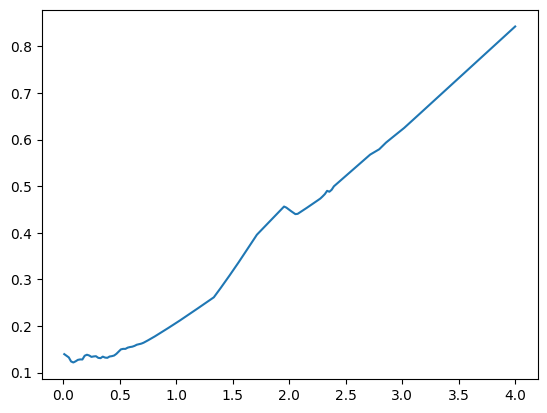

In [50]:
import matplotlib.pyplot as plt
sigmas = np.linspace(start=0.01, stop=4,num=200)
res = []
for sigma in sigmas:
    f = DSelect(X, y, sigma= sigma)
    res.append(np.linalg.norm(f[0]-theta_true,2))
plt.plot(sigmas,res)
plt.show()

Plus sigma est proche de 0, plus la distance entre l'estimation et la vraie valeur se réduit. On observe une valeur "palier" entre 0 et 0.5 environ où la distance ne s'améliore plus.

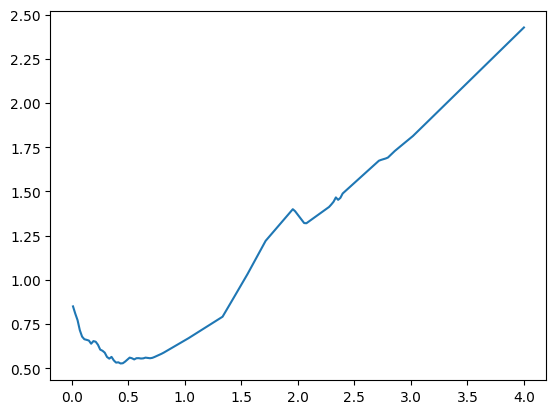

In [51]:
import matplotlib.pyplot as plt
sigmas = np.linspace(start=0.01, stop=4,num=200)
res = []
for sigma in sigmas:
    f = DSelect(X, y, sigma= sigma)
    res.append(np.linalg.norm(f[0]-theta_true,1))
plt.plot(sigmas,res)
plt.show()

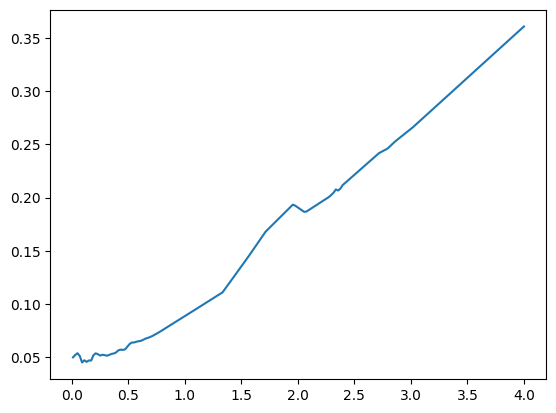

In [52]:
import matplotlib.pyplot as plt
sigmas = np.linspace(start=0.01, stop=4,num=200)
res = []
for sigma in sigmas:
    f = DSelect(X, y, sigma= sigma)
    res.append(np.linalg.norm(f[0]-theta_true,np.inf))
plt.plot(sigmas,res)
plt.show()

Mettre en log.

### Support des solutions

La valeur cherchée `theta_true` est très parcimonieuse (elle contient beaucoup de zéros). Les seules valeurs non-null sont aux positions suivantes.

In [40]:
S_set

[87, 254, 54, 225, 53, 91, 255, 99]

In [41]:
theta_true

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.90156277,  0.07907762,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

> **Question:** Comparez le nombre et l'emplacement des zéros dans `theta_ds` à ceux dans `theta_true`. Essayez de changer `c`.

In [42]:
print(len(S_set)) # Nombre de zeros dans theta_true
print(len(f[0][f[0]==0]))  # Nombre de zeros dans theta_ds

8
0


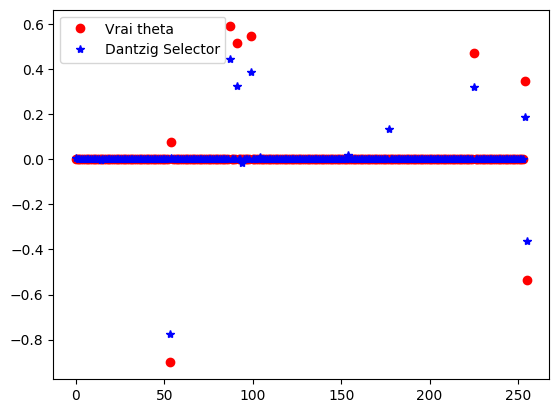

In [43]:
import matplotlib.pyplot as plt

plt.plot(theta_true,'ro',label='Vrai theta')
plt.plot(f[0],'b*',label='Dantzig Selector')
plt.legend();

On essaye de changer c

8
0


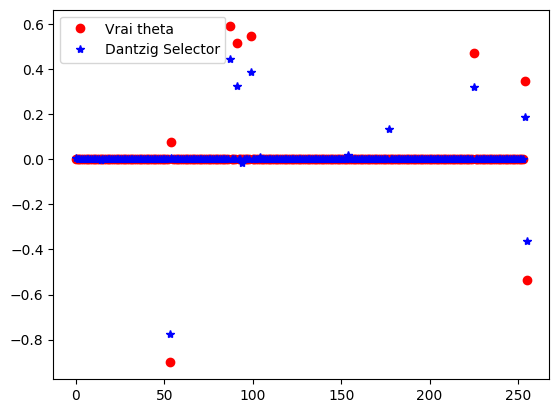

In [44]:
f = DSelect(X, y, sigma= sigma, c=1)
print(len(S_set)) # Nombre de zeros dans theta_true
print(len(f[0][f[0]==0]))  # Nombre de zeros dans theta_ds
plt.plot(theta_true,'ro',label='Vrai theta')
plt.plot(f[0],'b*',label='Dantzig Selector')
plt.legend();

8
0


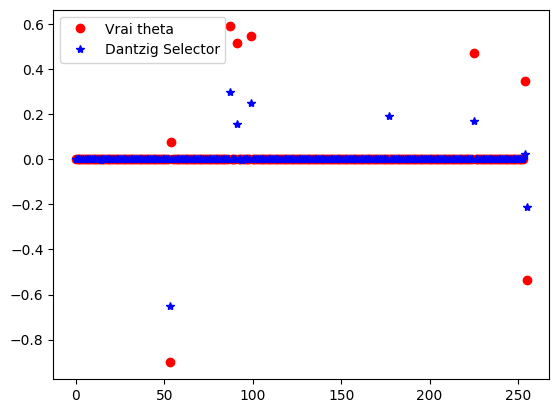

In [45]:
f = DSelect(X, y, sigma= sigma, c=2)
print(len(S_set)) # Nombre de zeros dans theta_true
print(len(f[0][f[0]==0]))  # Nombre de zeros dans theta_ds
plt.plot(theta_true,'ro',label='Vrai theta')
plt.plot(f[0],'b*',label='Dantzig Selector')
plt.legend();

8
0


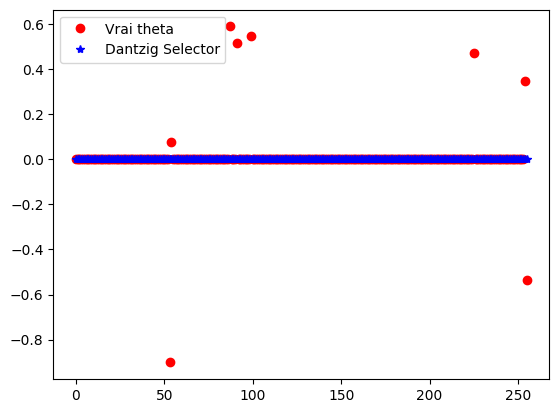

In [46]:
f = DSelect(X, y, sigma= sigma, c=10)
print(len(S_set)) # Nombre de zeros dans theta_true
print(len(f[0][f[0]==0]))  # Nombre de zeros dans theta_ds
plt.plot(theta_true,'ro',label='Vrai theta')
plt.plot(f[0],'b*',label='Dantzig Selector')
plt.legend();

8
0


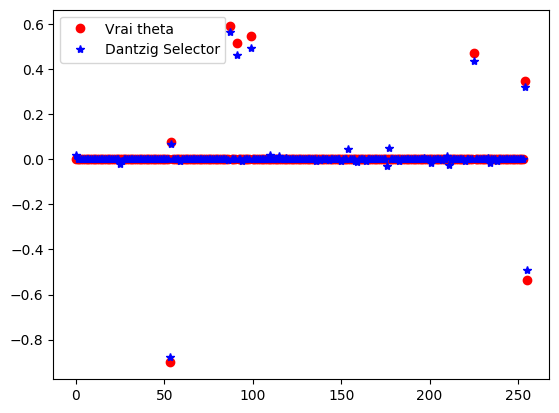

In [47]:
f = DSelect(X, y, sigma= sigma, c=0.1)
print(len(S_set)) # Nombre de zeros dans theta_true
print(len(f[0][f[0]==0]))  # Nombre de zeros dans theta_ds
plt.plot(theta_true,'ro',label='Vrai theta')
plt.plot(f[0],'b*',label='Dantzig Selector')
plt.legend();

8
0


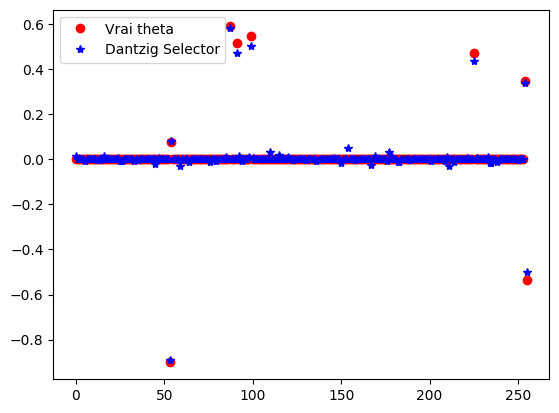

In [48]:
f = DSelect(X, y, sigma= sigma, c=0.01)
print(len(S_set)) # Nombre de zeros dans theta_true
print(len(f[0][f[0]==0]))  # Nombre de zeros dans theta_ds
plt.plot(theta_true,'ro',label='Vrai theta')
plt.plot(f[0],'b*',label='Dantzig Selector')
plt.legend();

Nous observons qu'en choisissant c plus petit, l'estimateur de Dantzig pour les points différents de 0 se rapproche de leur véritable valeur. Cependant, lorsque c devient trop petit (ici le cas c=0.01) on observe que les estimations pour les points réllement différents de 0 ne s'améliorent pas vraiment mais que les estimations pour les points effectivement égaux à 0 sont plus éloignées.

Il est donc nécessaire de trouver un juste milieu pour c, ce qui n'est pas forcément simple puisque dans la réalité on a pas la vraie valeur pour comparer.